In [77]:
import os
import numpy as np
import pandas as pd
from scipy.stats import poisson
from scipy.special import gammaln
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import norm
from sklearn.linear_model import PoissonRegressor

In [2]:
data = pd.read_csv("data3a.csv")

<h1>3 一般化線形モデル(GLM)</h1>

この章では説明変数を組み込んだ統計モデルについて扱う。  
第二章のモデルでは平均種子数$λ$は全個体で共通だとしてきた。  
ここでは個体ごとに異なる説明変数によって平均種子数$λ_i$が変化する統計モデルを扱う。  
このような統計モデルを観測データにあてはめることをポアソン回帰といい、これと似たような構造の統計モデルを総称して、一般化線形モデルという。

<h1>3.1 例題: 個体ごとに平均種子数が異なる場合</h1>

植物個体$i$の種子数は$y_i$個であり、さらに個体$i$の体の大きさを$x_i$  
全個体のうち半分の50個体は何も処理をしていないコントロール群とし、残り50個体には肥料を与える処理をしたとする。  
個体の大きさ$x_i$とは無関係に施肥処理が行われたとします。  

<h1>3.2 観測されたデータの概要を調べる<h1>

In [3]:
# データを表示
data

,y,x,f
0,6,8.31,C
1,6,9.44,C
2,6,9.50,C
3,12,9.07,C
4,10,10.16,C
...,...,...,...
95,8,9.15,T
96,6,8.52,T
97,8,10.24,T
98,7,10.86,T


In [4]:
# データ型を表示
data.dtypes

y      int64
x    float64
f     object
dtype: object

In [5]:
# データの統計値を表示
data.describe()

,y,x
count,100.000000,100.000000
mean,7.830000,10.089100
std,2.624881,1.008049
min,2.000000,7.190000
25%,6.000000,9.427500
50%,8.000000,10.155000
75%,10.000000,10.685000
max,15.000000,12.400000


In [6]:
# Cが施肥処理なし、Tが施肥処理あり
unique_f = data["f"].unique()
for f in unique_f:
  f_len = len(data[data["f"]==f])
  print(f"施肥処理{f}のサイズ: {f_len}個")

施肥処理Cのサイズ: 50個
施肥処理Tのサイズ: 50個


<h1>3.3 統計モデリングの前にデータを図示する</1>

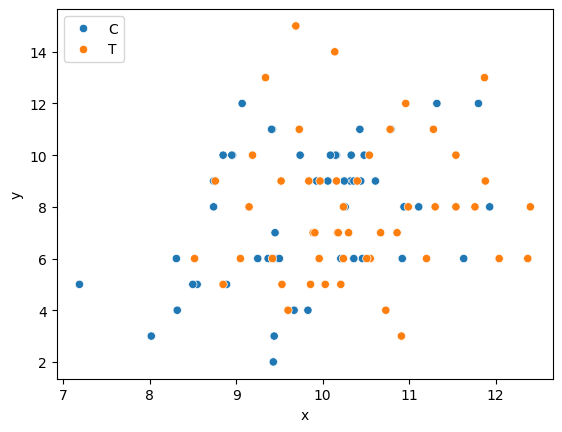

In [7]:
# xとyの関係性を見てみる
sns.scatterplot(data,x="x",y="y",hue="f")
plt.legend(loc="upper left")
plt.show()

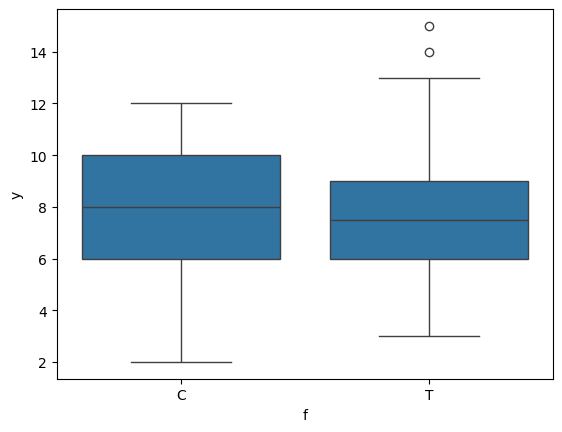

In [8]:
# fとyの関係性を見てみる
sns.boxplot(data,y="y",x="f")
plt.show()

これらの図をみて、なんとなくわかることは  
・体サイズ$x$が増加するにつれて、種子数$y$が増えているように見えるけどあまりはっきりしない  
・肥料の効果$f$は全然無いように見える  

<h1>3.4 ポアソン回帰の統計モデル</h1>

前の章では平均種子数$λ$は全個体で共通の値とした。  
この章の例題では個体ごとの平均種子数$λ_i$が体サイズ$x_i$や施肥処理$f_i$に影響されるモデルを設計する  
  
とりあえず施肥処理$f_i$はあまり種子数に影響がなさそうなので体サイズ$x_i$だけに依存するモデルを考えてみる。  
説明変数は$x_i$だけであり、応答変数は種子数$y_i$とする。  
ある個体$i$において種子数が$y_i$である確率$p(y_i|λ_i)$はポアソン分布に従い、  
$p(y_i|λ_i)=\frac{λ_i^{y_i}*exp(-λ_i)}{y_i!}$  
と仮定します


<h2>3.4.1 線形予測子と対数リンク関数</h2>

平均種子数$λ_i$を説明変数$x_i$の関数として定義する必要がある。  
$λ_i=exp(β1+β2x_i)$であるとしてみる。  
$β1$、$β2$はパラメータでありそれぞれ切方、傾きと呼ばれる。  
このモデルの数式は、  
$log(λ_i)=β1+β2x_i$と変形でき、  
この右辺は{β1$、$β2$}の線形結合になっており一般化線形モデルでは線形予測子と呼ばれる。  
($λ_i$の関数)=(線形予測子)となっている場合、左辺の「関数」はリンク関数と呼ばれる。  
この場合は$log$が使われているので対数リンク関数と呼ばれる。ポアソン回帰では、たいていの場合対数リンク関数が使われる。  

ポアソン回帰の一般化線形モデルでは対数リンク関数、  
ロジスティック回帰の一般化線形モデルではロジットリンク関数がよく使われ、  
ポアソン分布、二項分布の正準リンク関数と呼ばれる。  
  
ポアソン回帰で対数リンク関数を使う理由は「推定結果に都合よく」「わかりやすい」からです。  
ポアソン分布の$λ$は非負でなければならず、  
対数リンク関数$λ_i=exp(β1+β2x_i)$は説明変数やパラメータがどのような値になっても必ず非負となるため「推定結果に都合がよい」。  
また、要因の効果が積であらわされるため「わかりやすい」のである。  
$exp(x_i+1)=exp(x_i)*exp(1)$となって説明変数が1増えると$λ_iはexp(1)$倍されることがわかる。  
  
以下の図は$λ_i=exp(β1+β2x_i)$とした時に平均種子数$λ_i$と体サイズ$x_i$の関係


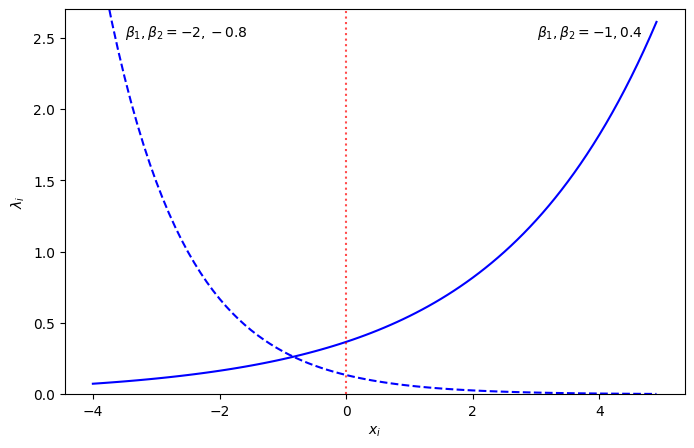

In [63]:
b1s=[-2,-1]
b2s=[-0.8,0.4]
x=np.arange(-4,5,0.1)
y_lim = 2.7

plt.figure(figsize=(8,5))
for b1,b2 in zip(b1s,b2s):
  if b2 < 0:
    linestyle = '--'
    ha = "left"
    x_pos = (np.log(y_lim-0.1)-b1)/b2 + 0.2
  else:
    linestyle = None
    ha = "right"
    x_pos = (np.log(y_lim-0.1)-b1)/b2 - 0.2
  lam = np.exp(b1+b2*x)
  # グラフ
  plt.plot(x,lam, color="blue",linestyle=linestyle) 
  plt.text(x=x_pos,y=2.6,
           s=rf"$\beta_1,\beta_2={b1},{b2}$",
           ha=ha,
           va="top"
          )
# x=0の点に縦線を引く
plt.axvline(x=0, color='red', linestyle=':', alpha=0.7)

plt.ylim(0, y_lim)
plt.xlabel(r"$x_i$")
plt.ylabel(r"$λ_i$")
plt.show()

<h2>3.4.2 あてはめとあてはまりのよさ</h2>

ポアソン回帰とは、観測データに対するポアソン分布を使った統計モデルのあてはめであり、  
対数尤度$logL$が最大になる$\beta_1と\beta_2$の推定値を求めること。  
このモデルの対数尤度は$logL(\beta_1,\beta_2)=\sum_i log(\frac{λ_i^{y_i}exp(-λ_i)}{y_i!})$となり  
線形予測子は$logλ_i=\beta_1+\beta_2$であり$λ_iが\beta_1と\beta_2$の関数になっている。  
ここでは$beta_1$、$beta_2$の最尤推定量の解析的な導出はせず、数値的な試行錯誤によって最尤推定値を探し出す  

In [10]:
"""
statsmodels:	回帰結果の統計量（p 値、信頼区間など）が充実
scikit-learn:	大規模データ向け、高速、正則化あり、機械学習向け
統計解析したい → statsmodels
予測モデルを作りたい → scikit-learn
"""
# 説明変数に切片を追加
X = sm.add_constant(data[["x"]])

# ポアソン回帰
model = sm.GLM(data["y"], X, family=sm.families.Poisson()).fit()

print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -235.39
Date:                Sat, 29 Nov 2025   Deviance:                       84.993
Time:                        00:49:55   Pearson chi2:                     83.8
No. Iterations:                     4   Pseudo R-squ. (CS):            0.04414
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2917      0.364      3.552      0.0

上側部分の見方を説明する。
 
Dep. Variable: y #目的変数  
No. Observations: 100 #データ数  
Model Family: Poisson	#ポアソン回帰  
Link Function: Log	#リンク関数。$log(λ_i)=\beta_1+\beta_2x_i$  
Df Residuals: 98  #残差の自由度  
Df Model: 1 #モデルの自由度  
Log-Likelihood: -235.39	#尤度  
Deviance : 84.993 #逸脱度、モデルの当てはまりの悪さを表す。$\frac{逸脱度}{残渣の自由度}$が1に近いほどよい  
Pearson chi2	#ピアソンのカイ二乗統計量。 $\frac{χ^2}{残渣の自由度}$が1に近いほどよい  
Pseudo R-squ.	#決定係数R²の近似。近似があまりよくないので参考にしない    

下側部分の見方を説明する。  
  
constは切片$\beta_1$、xは係数の傾き$\beta_2$に対応。  
coefは最尤推定値のこと。$\hat\beta_1=1.2917$、$\hat\beta_2=0.0757$となっている。  
std errはパラメータの標準偏差の推定値。$\hat\beta_1$と$\hat\beta_2$の「ばらつき」を標準偏差で表したもの。  
パラメータの推定値のばらつきとは「同じ調査方法で同数の別データをとりなおしても最尤推定値は変動する。そのばらつきぐあい」  
zはz値と呼ばれる統計量であり$\frac{最尤推定値}{標準誤差}$で見積もられる。  
P>|z|はp値と呼ばれる統計量であり、この値が大きいほどz値が0に近く推定値が0に近いことを表す(効果がない)。  
下の図の黒く塗りつぶされている面積の二倍  
[0.025, 0.975]は信頼区間  
  
ある説明変数をモデルに含めるか否かの判断はこのような統計量を使うのではなく、クロスバリデーションやAICを用いた予測誤差に基づいた方法により判断した方がよいかもしれない。  
「この説明変数をいれるかどうか」といった判断はあてはまりの改善ではなく、予測の改善を目的としているから  


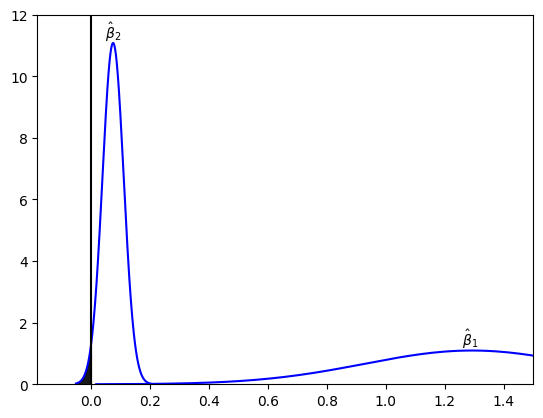

In [76]:
# パラメータのz検定の有意な部分を塗りつぶす
b_coefs=[1.2917,0.075]
b_stds=[0.364,0.036]
for i, b_coef,b_std in zip([1,2],b_coefs,b_stds):
  # プロット範囲
  x = np.linspace(b_coef - 3.5*b_std, b_coef + 3.5*b_std, 200)
  # 正規分布の密度
  y = norm.pdf(x, loc=b_coef, scale=b_std)
  # テキストを入れる座標
  max_idx = np.argmax(y)
  max_x = x[max_idx]
  max_y = y[max_idx]
  # 有意になる部分の面積
  mask = x<0
  x_fill = x[mask]
  y_fill = y[mask]

  plt.plot(x, y,color="blue")
  plt.text(x=max_x,y=max_y,
           s=fr"$\hat{{\beta}}_{i}$",
           ha="center",
           va="bottom"
          )
  if(len(x_fill)>0):
    plt.fill_between(x_fill,y_fill, color='black', alpha=0.9)
plt.axvline(0,color="black",linestyle="-")
plt.xlim(right=1.5)
plt.ylim([0,12])
plt.show()

<h2>3.4.3 ポアソン回帰モデルによる予測</h2>

このポアソン回帰の推定結果を使って、さまざまな体サイズxにおける平均種子数$λ$の予測をしてみる  
下の図は観測値に先ほど求めたポアソン回帰モデルの予測線を引いたもの

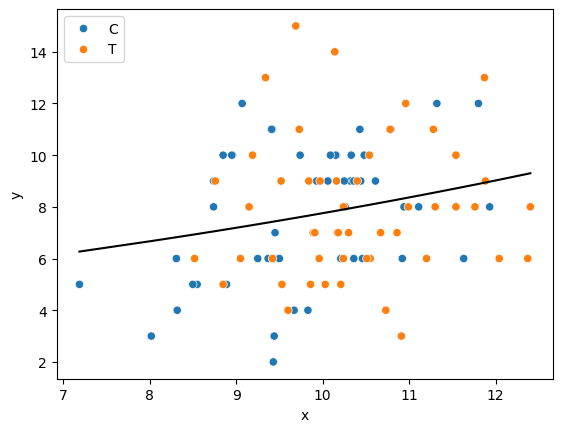

In [88]:
pred = model.predict(X)
# xとyの関係性を見てみる
sns.scatterplot(data,x="x",y="y",hue="f")
x_sorted_idx = np.argsort(data["x"])
plt.plot(data["x"].iloc[x_sorted_idx], pred.iloc[x_sorted_idx], color="black")
plt.legend(loc="upper left")
plt.show()